In [1]:
import numpy as np                         
import matplotlib                          
import matplotlib.pyplot as plt
from pykat import finesse                 
import pykat.optics.maps as pkm
from pykat.commands import *               
from pykat.optics.maps import *
import pandas as pd
import os
from scipy.special import factorial
from pykat.parallel import parakat

%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
kat = pykat.finesse.kat()
kat.verbose=False
kat.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 -34 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -1934.0
attr ETM Rc 2245.0

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [20]:
def theta(x,y):
    return np.where(x == 0, np.where(y>=0,np.pi/2,-np.pi/2), np.where(x>0,np.arctan(y/x),np.arctan(y/x)+np.pi))

def radial(x,y,n,m):
    if m<0:
        m=-m
    sum=0
    for k in range(int((n-m)/2)+1):   
        r=(-1)**k*factorial(n-k)/factorial(k)/factorial((n+m)/2-k)/factorial((n-m)/2-k)*((x**2+y**2)/(388**2))**(n/2-k)
        sum+=r
    return sum

def angular(x,y,n,m):
    a=theta(x,y)
    if m>=0:
        angular=np.cos(m*a)
    else:
        angular=-np.sin(m*a)
    return angular

def zmap(order,n,m):
    #the center of the map would be map[388][388]
    stepRange = np.arange(777)-388
    x,y=np.meshgrid(stepRange,stepRange,sparse=True)
    zfunc=radial(x,y,n,m)*angular(x,y,n,m)
#    print(radial(388,0,4,4))
    return order*zfunc/zfunc.max()

In [21]:
#generate 500*777*777 inputs

#coefficients of different zernikes for 500 samples
np.random.seed(42)
coeffs= np.random.rand(500,120)/90

#120 basis maps
_maps=[]
for n in range(15):
        for m in range(-n,n+1,2):
            _maps.append(zmap(1,n,m))

#500 randomly generated phase maps 
x_maps=[]
for i in range(500):
    component_maps=np.array(_maps)*coeffs[i].reshape(120,1,1)
    x_maps.append(component_maps.sum(axis=0))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctan
  


In [24]:
pd.Series(x_maps).to_pickle('pkl/CNNmapsinput.pkl')

In [2]:
x_maps = pd.read_pickle('pkl/CNNmapsinput.pkl').values

In [28]:
x_maps[0].max()-x_maps[0].min()
#this is to make sure that it has the same limits as the aLIGO map

59.9429099154661

In [11]:
#generate the phase maps into local repo

def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('temp.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('temp.txt',originalfile)

for i in range(500):
    path='sample_data/'
    filename=str(i)+'-th_phasemap.txt'
    np.savetxt(path+filename, x_maps[i], delimiter=' ',fmt='%1.4f')
    insert(path+filename,'''% Surface map
% Name: {}-th_phasemap
% Type: phase both
% Size: 777 777
% Optical center (x,y): 388 388
% Step size (x,y): 0.0004000000189989805 0.0004000000189989805
% Scaling: 1e-09\n\n\n'''.format(i))

In [12]:
kat1 = kat.deepcopy()
kat1.parse("""
        pd Ptrans n4
        map ETM Z22order0phasemap.txt
        """)
kat1.noxaxis = True
out1=kat1.run()
Power=out1["Ptrans"]

In [13]:
pk2=parakat()
for i in range(500):
    kat2 = kat.deepcopy()
    kat2.parse("""
            map ETM sample_data/{}-th_phasemap.txt
            ad AD33 3 3 0 n4
            """.format(i))
    kat2.noxaxis = True
    pk2.run(kat2)
out2 = pk2.getResults()

/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs:  99%|######################################################### |

In [14]:
lossZnm=[]
for i in range(500):
    loss=1 - out2[i]['AD33']**2/Power
    lossZnm.append(loss)

pd.Series(lossZnm).to_pickle('pkl/CNNlossZnm.pkl')

In [3]:
lossZnm_array = pd.read_pickle('pkl/CNNlossZnm.pkl').values

In [4]:
dataset=pd.DataFrame({'x_maps':x_maps,
             'loss': lossZnm_array})

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('loss')
test_labels = test_dataset.pop('loss')

train_dataset=train_dataset.values
x=list(train_dataset.reshape(400))
train_data = np.zeros((400,777,777,1))
for i in range(400):
    train_data[i,:,:,0] = x[i]
    
train_labels=train_labels.values


test_dataset=test_dataset.values
y=list(test_dataset.reshape(100))
test_data = np.zeros((100,777,777,1))
for i in range(100):
    test_data[i,:,:,0] = y[i]

test_labels=test_labels.values

In [5]:
min=train_labels.min()
max=train_labels.max()
print(min,max)
test_labels = (test_labels-min)/(max-min)
train_labels = (train_labels-min)/(max-min)

0.004748945797184767 0.00701910172568232


In [45]:
# #prepare the data:
# for i in range(400):
#     train_data[i]=(train_data[i]-np.mean(train_data[i]))/np.std(train_data[i])
    
# for j in range(100):
#     test_data[j]=(test_data[j]-np.mean(test_data[j]))/np.std(test_data[j])

# #split into validation and test samples
# #val_data=test_data[:50]
# #test_data=test_data[50:]

# #val_labels=test_labels[:50]
# #test_labels=test_labels[50:]

In [6]:
train_data.shape

(400, 777, 777, 1)

In [7]:
train_labels.shape

(400,)

In [8]:
test_data.shape

(100, 777, 777, 1)

In [9]:
test_labels.shape

(100,)

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [51]:
#model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(777, 777,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

optimizer = tf.keras.optimizers.RMSprop(0.001)

model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 775, 775, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 387, 387, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 385, 385, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 192, 192, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 190, 190, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 288800)            0

In [22]:
#total number of epochs equals to 100
history = model.fit(train_data, train_labels,batch_size=10,epochs=20)

Train on 400 samples
Epoch 1/20
400/400 [==============================] - 82s 204ms/sample - loss: 1.9965e-06 - mae: 0.0013 - mse: 1.9965e-06
Epoch 2/20
400/400 [==============================] - 68s 171ms/sample - loss: 1.8448e-06 - mae: 0.0013 - mse: 1.8448e-06
Epoch 3/20
400/400 [==============================] - 72s 180ms/sample - loss: 9.1381e-07 - mae: 7.3078e-04 - mse: 9.1381e-07
Epoch 4/20
400/400 [==============================] - 76s 190ms/sample - loss: 8.9887e-07 - mae: 6.6824e-04 - mse: 8.9887e-07
Epoch 5/20
400/400 [==============================] - 68s 171ms/sample - loss: 1.3808e-06 - mae: 0.0011 - mse: 1.3808e-06
Epoch 6/20
400/400 [==============================] - 71s 178ms/sample - loss: 1.2509e-06 - mae: 9.7541e-04 - mse: 1.2509e-06
Epoch 7/20
400/400 [==============================] - 73s 182ms/sample - loss: 1.0689e-06 - mae: 9.0646e-04 - mse: 1.0689e-06
Epoch 8/20
400/400 [==============================] - 74s 186ms/sample - loss: 9.0271e-07 - mae: 8.3449e-04 -

In [11]:
#load the model
model=keras.models.load_model("models/300_epochs.h5")

In [13]:
loss, mae, mse = model.evaluate(test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.4f} ".format(mae))

100/100 - 7s - loss: 0.0010 - mae: 0.0250 - mse: 0.0010
Testing set Mean Abs Error: 0.0250 


In [17]:
i=20
prediction = model.predict(test_data)
print("the prediction is {} and the corresponding simulation value is {}:".format(prediction[i],test_labels[i]))
#print("the accuracy is {}".format(2*abs(prediction[i]-test_labels[i])/(prediction[i]+test_labels[i])))

the prediction is [0.27847943] and the corresponding simulation value is 0.2548971509604618:


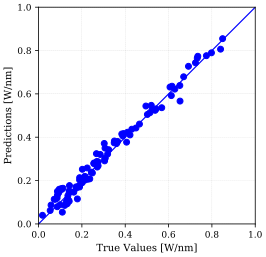

In [18]:
test_predictions = model.predict(test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [W/nm]')
plt.ylabel('Predictions [W/nm]')
lims = [0,1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

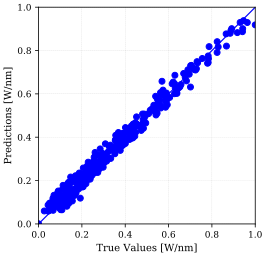

In [19]:
train_predictions = model.predict(train_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [W/nm]')
plt.ylabel('Predictions [W/nm]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [24]:
model.save("models/model.h5")  # name it whatever you want but end with .h5

In [11]:
#model = keras.models.load_model("models/model.h5")